## 3D MedNeXt

In [ ]:
%%bash

git clone https://github.com/MIC-DKFZ/MedNeXt.git mednext
cd mednext
pip install -e .

Obtaining file:///content/mednext
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuf

Cloning into 'mednext'...


# 3D Image Classification from CT Scans

**Description:** Train a 3D convolutional neural network to predict presence of pneumonia.

## Introduction

This example will show the steps needed to build a 3D convolutional neural network (CNN)
to predict the presence of viral pneumonia in computer tomography (CT) scans. 2D CNNs are
commonly used to process RGB images (3 channels). A 3D CNN is simply the 3D
equivalent: it takes as input a 3D volume or a sequence of 2D frames (e.g. slices in a CT scan),
3D CNNs are a powerful model for learning representations for volumetric data.

## References

- [A survey on Deep Learning Advances on Different 3D DataRepresentations](https://arxiv.org/pdf/1808.01462.pdf)
- [VoxNet: A 3D Convolutional Neural Network for Real-Time Object Recognition](https://www.ri.cmu.edu/pub_files/2015/9/voxnet_maturana_scherer_iros15.pdf)
- [FusionNet: 3D Object Classification Using MultipleData Representations](http://3ddl.cs.princeton.edu/2016/papers/Hegde_Zadeh.pdf)
- [Uniformizing Techniques to Process CT scans with 3D CNNs for Tuberculosis Prediction](https://arxiv.org/abs/2007.13224)

## Setup

In [ ]:
!pip install torch fvcore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61398 sha256=b2a8bd17e274d23a32266b3d92ccb80fd235d1e784a108e1c4b7800cc80253b7
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31531 sha256=c90d9ce57e8893b310d83db6a6ab624d3bf00dc10c301dc222f6f44406cdc92c
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath


In [ ]:
import os
import zipfile
import numpy as np
import torch  # for data preprocessing
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import random
import urllib.request
import numpy as np
import nibabel as nib


from scipy import ndimage
from torch.utils.data import Dataset, DataLoader

## Downloading the MosMedData: Chest CT Scans with COVID-19 Related Findings

In this example, we use a subset of the
[MosMedData: Chest CT Scans with COVID-19 Related Findings](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1).
This dataset consists of lung CT scans with COVID-19 related findings, as well as without such findings.

We will be using the associated radiological findings of the CT scans as labels to build
a classifier to predict presence of viral pneumonia.
Hence, the task is a binary classification problem.

In [ ]:
import os
import zipfile
import urllib.request

# Download url of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
urllib.request.urlretrieve(url, filename)

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
urllib.request.urlretrieve(url, filename)

# Make a directory to store the data.
os.makedirs("MosMedData", exist_ok=True)

# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

## Loading data and preprocessing

The files are provided in Nifti format with the extension .nii. To read the
scans, we use the `nibabel` package.
You can install the package via `pip install nibabel`. CT scans store raw voxel
intensity in Hounsfield units (HU). They range from -1024 to above 2000 in this dataset.
Above 400 are bones with different radiointensity, so this is used as a higher bound. A threshold
between -1000 and 400 is commonly used to normalize CT scans.

To process the data, we do the following:

* We first rotate the volumes by 90 degrees, so the orientation is fixed
* We scale the HU values to be between 0 and 1.
* We resize width, height and depth.

Here we define several helper functions to process the data. These functions
will be used when building training and validation datasets.

In [ ]:
# Define helper functions
def read_nifti_file(filepath):
    """Read and load volume"""
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan

def normalize(volume):
    """Normalize the volume"""
    min, max = -1000, 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume

def resize_volume(img):
    """Resize across z-axis"""
    desired_depth, desired_width, desired_height = 64, 128, 128
    current_depth, current_width, current_height = img.shape[-1], img.shape[0], img.shape[1]
    depth_factor, width_factor, height_factor = current_depth / desired_depth, current_width / desired_width, current_height / desired_height
    img = ndimage.rotate(img, 90, reshape=False)
    img = ndimage.zoom(img, (1 / width_factor, 1 / height_factor, 1 / depth_factor), order=1)
    return img

def process_scan(path):
    """Read and resize volume"""
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = resize_volume(volume)
    return volume

Let's read the paths of the CT scans from the class directories.

In [ ]:
import os

# Folder "CT-0" consists of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
    if x.endswith(".gz")  # Assuming the files are in NIfTI format
]

# Folder "CT-23" consists of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
    if x.endswith(".gz")  # Assuming the files are in NIfTI format
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


## Build train and validation datasets
Read the scans from the class directories and assign labels. Downsample the scans to have
shape of 128x128x64. Rescale the raw HU values to the range 0 to 1.
Lastly, split the dataset into train and validation subsets.

In [ ]:
normal_scans = [process_scan(path) for path in normal_scan_paths]
abnormal_scans = [process_scan(path) for path in abnormal_scan_paths]

normal_labels = [0 for _ in range(len(normal_scans))]
abnormal_labels = [1 for _ in range(len(abnormal_scans))]

all_scans = normal_scans + abnormal_scans
all_labels = normal_labels + abnormal_labels

indices = np.random.permutation(len(all_scans))
train_indices, val_indices = indices[:int(0.7 * len(indices))], indices[int(0.7 * len(indices)):]

print(f"Total scans: {len(all_scans)}, Training scans: {len(train_indices)}, Validation scans: {len(val_indices)}")

Total scans: 200, Training scans: 140, Validation scans: 60


## Data augmentation

The CT scans also augmented by rotating at random angles during training. Since
the data is stored in rank-3 tensors of shape `(samples, height, width, depth)`,
we add a dimension of size 1 at axis 4 to be able to perform 3D convolutions on
the data. The new shape is thus `(samples, height, width, depth, 1)`. There are
different kinds of preprocessing and augmentation techniques out there,
this example shows a few simple ones to get started.

While defining the train and validation data loader, the training data is passed through
and augmentation function which randomly rotates volume at different angles. Note that both
training and validation data are already rescaled to have values between 0 and 1.

In [ ]:
class CTScanDataset(Dataset):
    def __init__(self, scan_paths, labels, train=True, transform=None):
        self.scan_paths = scan_paths
        self.labels = labels
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.scan_paths)

    def __getitem__(self, idx):
        volume = self.scan_paths[idx]
        label = self.labels[idx]

        if self.train:
            volume = rotate(volume)

        if self.transform:
            volume = self.transform(volume)

        volume = np.expand_dims(volume, axis=0)  # Adding a channel dimension
        return torch.tensor(volume, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [ ]:
def rotate(volume):
    """Rotate the volume by a few degrees"""
    angles = [-20, -10, -5, 5, 10, 20]
    angle = random.choice(angles)
    volume = ndimage.rotate(volume, angle, reshape=False)
    volume[volume < 0] = 0
    volume[volume > 1] = 1
    return volume

In [ ]:
 # Create datasets
train_dataset = CTScanDataset([all_scans[i] for i in train_indices], [all_labels[i] for i in train_indices], train=True)
val_dataset = CTScanDataset([all_scans[i] for i in val_indices], [all_labels[i] for i in val_indices], train=False)

print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}")

# Create data loaders
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Data loaders created successfully.")

Train dataset size: 140, Validation dataset size: 60
Data loaders created successfully.


Visualize an augmented CT scan.

Dimension of the CT scan is: (1, 128, 128, 64)


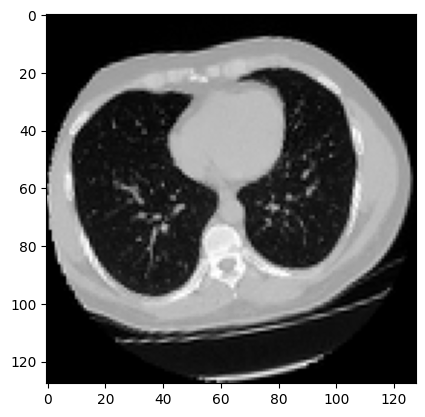

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of data from the training loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert the images tensor to a numpy array
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)

# Display a slice from the CT scan
plt.imshow(np.squeeze(image[:, :, :, 26]), cmap="gray")
plt.show()

Since a CT scan has many slices, let's visualize a montage of the slices.

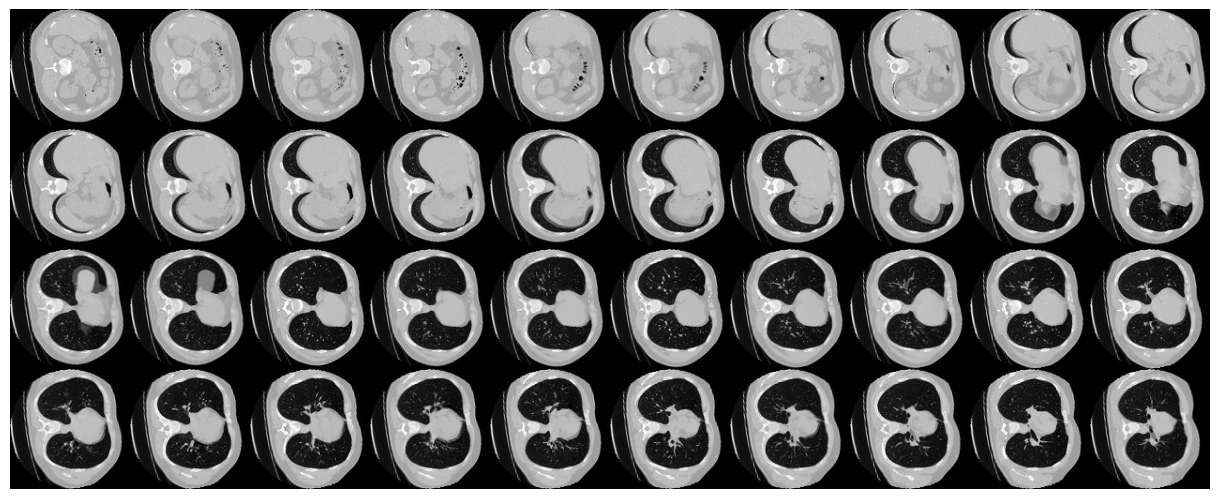

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :, :40])

## Define a 3D convolutional neural network

To make the model easier to understand, we structure it into blocks.
The architecture of the 3D CNN used in this example
is based on [this paper](https://arxiv.org/abs/2007.13224).

### Baseline 3D model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN3D(nn.Module):
    def __init__(self):
        super(CNN3D, self).__init__()
        self.conv1 = nn.Conv3d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(64)
        self.pool = nn.MaxPool3d(2)

        self.conv2 = nn.Conv3d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(64)

        self.conv3 = nn.Conv3d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm3d(128)

        self.conv4 = nn.Conv3d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm3d(256)

        self.global_avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc1 = nn.Linear(256, 512)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Build model.
model = CNN3D()
print(model)

### MedNeXt model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MedNeXtBlock(nn.Module):

    def __init__(self,
                in_channels:int,
                out_channels:int,
                exp_r:int=4,
                kernel_size:int=7,
                do_res:int=True,
                norm_type:str = 'group',
                n_groups:int or None = None,
                dim = '3d',
                grn = False
                ):

        super().__init__()

        self.do_res = do_res

        assert dim in ['2d', '3d']
        self.dim = dim
        if self.dim == '2d':
            conv = nn.Conv2d
        elif self.dim == '3d':
            conv = nn.Conv3d

        # First convolution layer with DepthWise Convolutions
        self.conv1 = conv(
            in_channels = in_channels,
            out_channels = in_channels,
            kernel_size = kernel_size,
            stride = 1,
            padding = kernel_size//2,
            groups = in_channels if n_groups is None else n_groups,
        )

        # Normalization Layer. GroupNorm is used by default.
        if norm_type=='group':
            self.norm = nn.GroupNorm(
                num_groups=in_channels,
                num_channels=in_channels
                )
        elif norm_type=='layer':
            self.norm = LayerNorm(
                normalized_shape=in_channels,
                data_format='channels_first'
                )

        # Second convolution (Expansion) layer with Conv3D 1x1x1
        self.conv2 = conv(
            in_channels = in_channels,
            out_channels = exp_r*in_channels,
            kernel_size = 1,
            stride = 1,
            padding = 0
        )

        # GeLU activations
        self.act = nn.GELU()

        # Third convolution (Compression) layer with Conv3D 1x1x1
        self.conv3 = conv(
            in_channels = exp_r*in_channels,
            out_channels = out_channels,
            kernel_size = 1,
            stride = 1,
            padding = 0
        )

        self.grn = grn
        if grn:
            if dim == '3d':
                self.grn_beta = nn.Parameter(torch.zeros(1,exp_r*in_channels,1,1,1), requires_grad=True)
                self.grn_gamma = nn.Parameter(torch.zeros(1,exp_r*in_channels,1,1,1), requires_grad=True)
            elif dim == '2d':
                self.grn_beta = nn.Parameter(torch.zeros(1,exp_r*in_channels,1,1), requires_grad=True)
                self.grn_gamma = nn.Parameter(torch.zeros(1,exp_r*in_channels,1,1), requires_grad=True)


    def forward(self, x, dummy_tensor=None):

        x1 = x
        x1 = self.conv1(x1)
        x1 = self.act(self.conv2(self.norm(x1)))
        if self.grn:
            # gamma, beta: learnable affine transform parameters
            # X: input of shape (N,C,H,W,D)
            if self.dim == '3d':
                gx = torch.norm(x1, p=2, dim=(-3, -2, -1), keepdim=True)
            elif self.dim == '2d':
                gx = torch.norm(x1, p=2, dim=(-2, -1), keepdim=True)
            nx = gx / (gx.mean(dim=1, keepdim=True)+1e-6)
            x1 = self.grn_gamma * (x1 * nx) + self.grn_beta + x1
        x1 = self.conv3(x1)
        if self.do_res:
            x1 = x + x1
        return x1


class MedNeXtDownBlock(MedNeXtBlock):

    def __init__(self, in_channels, out_channels, exp_r=4, kernel_size=7,
                do_res=False, norm_type = 'group', dim='3d', grn=False):

        super().__init__(in_channels, out_channels, exp_r, kernel_size,
                        do_res = False, norm_type = norm_type, dim=dim,
                        grn=grn)

        if dim == '2d':
            conv = nn.Conv2d
        elif dim == '3d':
            conv = nn.Conv3d
        self.resample_do_res = do_res
        if do_res:
            self.res_conv = conv(
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = 1,
                stride = 2
            )

        self.conv1 = conv(
            in_channels = in_channels,
            out_channels = in_channels,
            kernel_size = kernel_size,
            stride = 2,
            padding = kernel_size//2,
            groups = in_channels,
        )

    def forward(self, x, dummy_tensor=None):

        x1 = super().forward(x)

        if self.resample_do_res:
            res = self.res_conv(x)
            x1 = x1 + res

        return x1


class MedNeXtUpBlock(MedNeXtBlock):

    def __init__(self, in_channels, out_channels, exp_r=4, kernel_size=7,
                do_res=False, norm_type = 'group', dim='3d', grn = False):
        super().__init__(in_channels, out_channels, exp_r, kernel_size,
                         do_res=False, norm_type = norm_type, dim=dim,
                         grn=grn)

        self.resample_do_res = do_res

        self.dim = dim
        if dim == '2d':
            conv = nn.ConvTranspose2d
        elif dim == '3d':
            conv = nn.ConvTranspose3d
        if do_res:
            self.res_conv = conv(
                in_channels = in_channels,
                out_channels = out_channels,
                kernel_size = 1,
                stride = 2
                )

        self.conv1 = conv(
            in_channels = in_channels,
            out_channels = in_channels,
            kernel_size = kernel_size,
            stride = 2,
            padding = kernel_size//2,
            groups = in_channels,
        )


    def forward(self, x, dummy_tensor=None):

        x1 = super().forward(x)
        # Asymmetry but necessary to match shape

        if self.dim == '2d':
            x1 = torch.nn.functional.pad(x1, (1,0,1,0))
        elif self.dim == '3d':
            x1 = torch.nn.functional.pad(x1, (1,0,1,0,1,0))

        if self.resample_do_res:
            res = self.res_conv(x)
            if self.dim == '2d':
                res = torch.nn.functional.pad(res, (1,0,1,0))
            elif self.dim == '3d':
                res = torch.nn.functional.pad(res, (1,0,1,0,1,0))
            x1 = x1 + res

        return x1


class OutBlock(nn.Module):

    def __init__(self, in_channels, n_classes, dim):
        super().__init__()

        if dim == '2d':
            conv = nn.ConvTranspose2d
        elif dim == '3d':
            conv = nn.ConvTranspose3d
        self.conv_out = conv(in_channels, n_classes, kernel_size=1)

    def forward(self, x, dummy_tensor=None):
        return self.conv_out(x)


class LayerNorm(nn.Module):
    """ LayerNorm that supports two data formats: channels_last (default) or channels_first.
    The ordering of the dimensions in the inputs. channels_last corresponds to inputs with
    shape (batch_size, height, width, channels) while channels_first corresponds to inputs
    with shape (batch_size, channels, height, width).
    """
    def __init__(self, normalized_shape, eps=1e-5, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))        # beta
        self.bias = nn.Parameter(torch.zeros(normalized_shape))         # gamma
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )

    def forward(self, x, dummy_tensor=False):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None, None] * x + self.bias[:, None, None, None]
            return x

In [ ]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint


class MedNeXt(nn.Module):

    def __init__(self,
        in_channels: int,
        n_channels: int,
        n_classes: int = 1,                      # Set n_classes to 1 for binary classification
        exp_r: int = 4,                            # Expansion ratio as in Swin Transformers
        kernel_size: int = 7,                      # Of course can test kernel_size
        enc_kernel_size: int = None,
        deep_supervision: bool = False,             # Can be used to test deep supervision
        do_res: bool = False,                       # Can be used to individually test residual connection
        checkpoint_style: bool = None,            # Either inside block or outside block
        block_counts: list = [2,2,2,2,2,2,2,2,2], # Can be used to test staging ratio:
                                            # [3,3,9,3] in Swin as opposed to [2,2,2,2,2] in nnUNet
        norm_type = 'group',
        dim = '3d',                                # 2d or 3d
        grn = False
    ):

        super().__init__()

        self.do_ds = deep_supervision
        assert checkpoint_style in [None, 'outside_block']
        self.inside_block_checkpointing = False
        self.outside_block_checkpointing = False
        if checkpoint_style == 'outside_block':
            self.outside_block_checkpointing = True
        assert dim in ['2d', '3d']

        if kernel_size is not None:
            enc_kernel_size = kernel_size

        if dim == '2d':
            conv = nn.Conv2d
        elif dim == '3d':
            conv = nn.Conv3d

        self.stem = conv(in_channels, n_channels, kernel_size=1)
        if type(exp_r) == int:
            exp_r = [exp_r for i in range(len(block_counts))]

        self.enc_block_0 = nn.Sequential(*[
            MedNeXtBlock(
                in_channels=n_channels,
                out_channels=n_channels,
                exp_r=exp_r[0],
                kernel_size=enc_kernel_size,
                do_res=do_res,
                norm_type=norm_type,
                dim=dim,
                grn=grn
                )
            for i in range(block_counts[0])]
        )

        self.down_0 = MedNeXtDownBlock(
            in_channels=n_channels,
            out_channels=2*n_channels,
            exp_r=exp_r[1],
            kernel_size=enc_kernel_size,
            do_res=do_res,
            norm_type=norm_type,
            dim=dim
        )

        self.enc_block_1 = nn.Sequential(*[
            MedNeXtBlock(
                in_channels=n_channels*2,
                out_channels=n_channels*2,
                exp_r=exp_r[1],
                kernel_size=enc_kernel_size,
                do_res=do_res,
                norm_type=norm_type,
                dim=dim,
                grn=grn
                )
            for i in range(block_counts[1])]
        )

        self.down_1 = MedNeXtDownBlock(
            in_channels=2*n_channels,
            out_channels=4*n_channels,
            exp_r=exp_r[2],
            kernel_size=enc_kernel_size,
            do_res=do_res,
            norm_type=norm_type,
            dim=dim,
            grn=grn
        )

        self.enc_block_2 = nn.Sequential(*[
            MedNeXtBlock(
                in_channels=n_channels*4,
                out_channels=n_channels*4,
                exp_r=exp_r[2],
                kernel_size=enc_kernel_size,
                do_res=do_res,
                norm_type=norm_type,
                dim=dim,
                grn=grn
                )
            for i in range(block_counts[2])]
        )

        self.down_2 = MedNeXtDownBlock(
            in_channels=4*n_channels,
            out_channels=8*n_channels,
            exp_r=exp_r[3],
            kernel_size=enc_kernel_size,
            do_res=do_res,
            norm_type=norm_type,
            dim=dim,
            grn=grn
        )

        self.enc_block_3 = nn.Sequential(*[
            MedNeXtBlock(
                in_channels=n_channels*8,
                out_channels=n_channels*8,
                exp_r=exp_r[3],
                kernel_size=enc_kernel_size,
                do_res=do_res,
                norm_type=norm_type,
                dim=dim,
                grn=grn
                )
            for i in range(block_counts[3])]
        )

        self.down_3 = MedNeXtDownBlock(
            in_channels=8*n_channels,
            out_channels=16*n_channels,
            exp_r=exp_r[4],
            kernel_size=enc_kernel_size,
            do_res=do_res,
            norm_type=norm_type,
            dim=dim,
            grn=grn
        )

        self.bottleneck = nn.Sequential(*[
            MedNeXtBlock(
                in_channels=n_channels*16,
                out_channels=n_channels*16,
                exp_r=exp_r[4],
                kernel_size=enc_kernel_size,
                do_res=do_res,
                norm_type=norm_type,
                dim=dim,
                grn=grn
                )
            for i in range(block_counts[4])]
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool3d((1, 1, 1)),
            nn.Flatten(),
            nn.Linear(n_channels * 16, n_classes),
            nn.Sigmoid()                         # Adding Sigmoid activation for binary classification
        )

        # Used to fix PyTorch checkpointing bug
        self.dummy_tensor = nn.Parameter(torch.tensor([1.]), requires_grad=True)

        self.block_counts = block_counts


    def iterative_checkpoint(self, sequential_block, x):
        """
        This simply forwards x through each block of the sequential_block while
        using gradient_checkpointing. This implementation is designed to bypass
        the following issue in PyTorch's gradient checkpointing:
        https://discuss.pytorch.org/t/checkpoint-with-no-grad-requiring-inputs-problem/19117/9
        """
        for l in sequential_block:
            x = checkpoint.checkpoint(l, x, self.dummy_tensor)
        return x


    def forward(self, x):

        x = self.stem(x)
        if self.outside_block_checkpointing:
            x = self.iterative_checkpoint(self.enc_block_0, x)
            x = checkpoint.checkpoint(self.down_0, x, self.dummy_tensor)
            x = self.iterative_checkpoint(self.enc_block_1, x)
            x = checkpoint.checkpoint(self.down_1, x, self.dummy_tensor)
            x = self.iterative_checkpoint(self.enc_block_2, x)
            x = checkpoint.checkpoint(self.down_2, x, self.dummy_tensor)
            x = self.iterative_checkpoint(self.enc_block_3, x)
            x = checkpoint.checkpoint(self.down_3, x, self.dummy_tensor)
            x = self.iterative_checkpoint(self.bottleneck, x)
        else:
            x = self.enc_block_0(x)
            x = self.down_0(x)
            x = self.enc_block_1(x)
            x = self.down_1(x)
            x = self.enc_block_2(x)
            x = self.down_2(x)
            x = self.enc_block_3(x)
            x = self.down_3(x)
            x = self.bottleneck(x)

        x = self.classifier(x)

        return x


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Train model

In [ ]:
def train_one_epoch(model, optimizer, criterion, dataloader, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

def evaluate(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            running_loss += loss.item() * inputs.size(0)
            preds = (outputs.squeeze() > 0.5).float()
            correct_predictions += torch.sum(preds == labels).item()
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = correct_predictions / len(dataloader.dataset)
    return epoch_loss, accuracy

In [ ]:
network = MedNeXt(
    in_channels=1,
    n_channels=32,
    n_classes=1,                     # Set n_classes to 1 for binary classification
    exp_r=[2, 3, 4, 4, 4, 4, 4, 3, 2],         # Expansion ratio as in Swin Transformers
    kernel_size=3,                     # Can test kernel_size
    deep_supervision=False,            # No deep supervision for classification
    do_res=True,                      # Can be used to individually test residual connection
    block_counts=[3, 4, 8, 8, 8, 8, 8, 4, 3],
    checkpoint_style=None,
    dim='3d',
    grn=True
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
network.to(device)

MedNeXt(
  (stem): Conv3d(1, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (enc_block_0): Sequential(
    (0): MedNeXtBlock(
      (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32)
      (norm): GroupNorm(32, 32, eps=1e-05, affine=True)
      (conv2): Conv3d(32, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (act): GELU(approximate='none')
      (conv3): Conv3d(64, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
    (1): MedNeXtBlock(
      (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32)
      (norm): GroupNorm(32, 32, eps=1e-05, affine=True)
      (conv2): Conv3d(32, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1))
      (act): GELU(approximate='none')
      (conv3): Conv3d(64, 32, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
    (2): MedNeXtBlock(
      (conv1): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32)
      (norm): GroupNorm(32, 32, eps=1e-05

In [ ]:
print(f"Total parameters: {count_parameters(network)}")

Total parameters: 23690562


In [ ]:
optimizer = optim.Adam(network.parameters(), lr=0.001)
criterion = nn.BCELoss()

num_epochs = 10
best_val_loss = float('inf')

In [ ]:
for epoch in range(num_epochs):
    train_loss = train_one_epoch(network, optimizer, criterion, train_loader, device)
    val_loss, val_accuracy = evaluate(network, criterion, val_loader, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(network.state_dict(), "best_model.pth")
        print("Saved best model")

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 

It is important to note that the number of samples is very small (only 200) and we don't
specify a random seed. As such, you can expect significant variance in the results. The full dataset
which consists of over 1000 CT scans can be found [here](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1). Using the full
dataset, an accuracy of 83% was achieved. A variability of 6-7% in the classification
performance is observed in both cases.

## Visualizing model performance

Here the model accuracy and loss for the training and the validation sets are plotted.
Since the validation set is class-balanced, accuracy provides an unbiased representation
of the model's performance.

KeyError: 'acc'

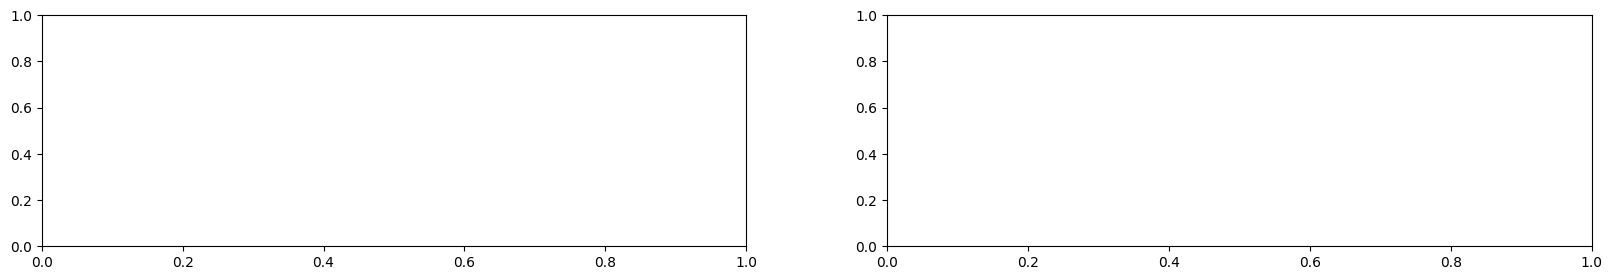

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## Make predictions on a single CT scan

In [ ]:
# Load best weights.
model.load_weights("mednext_classification.keras")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
This model is 48.82 percent confident that CT scan is normal
This model is 51.18 percent confident that CT scan is abnormal
